# LG3 MLP baseline (weekly lag) demo

Use same-weekday data from 1 week and 2 weeks ago to predict the target day.

In [13]:
import os
from datetime import timedelta

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# --- config ---
DATA_ROOT = os.path.abspath(os.path.join('..', 'data', 'processed_data'))
SOURCES = ['elec1_f2', 'ohsung_f2']
TARGET_COL = 'Power'
FREQ = '5min'
DAY_STEPS = 288  # 24h at 5-min
EPOCHS = 20
LR = 1e-3
BATCH_SIZE = 128


In [14]:
def load_split(split):
    dfs = []
    for source in SOURCES:
        path = os.path.join(DATA_ROOT, source, f'lg3_{split}.csv')
        df = pd.read_csv(path, parse_dates=[0], index_col=0)
        df = df.select_dtypes(include=[np.number]).dropna(how='any')
        df = df[~df.index.duplicated(keep='first')]
        dfs.append(df[[TARGET_COL]].sort_index())
    return pd.concat(dfs, axis=0).sort_index()


def build_daily_map(df):
    df = df[~df.index.duplicated(keep='first')]
    daily = {}
    for d in pd.to_datetime(df.index.date).unique():
        day_start = pd.to_datetime(d)
        day_index = pd.date_range(day_start, day_start + timedelta(days=1) - pd.to_timedelta(FREQ), freq=FREQ)
        day_series = df.loc[day_start:day_start + timedelta(days=1) - pd.to_timedelta(FREQ)].reindex(day_index)
        if day_series.isna().any().any():
            continue
        if len(day_series) == DAY_STEPS:
            daily[day_start.date()] = day_series[TARGET_COL].values.astype(np.float32)
    return daily


In [15]:
def build_weekly_lag_samples(df):
    daily = build_daily_map(df)
    dates = sorted(daily.keys())
    X, y, y_dates = [], [], []
    for d in dates:
        d1 = d - timedelta(days=7)
        d2 = d - timedelta(days=14)
        if d1 in daily and d2 in daily:
            x = np.concatenate([daily[d2], daily[d1]])  # 2 days input
            X.append(x)
            y.append(daily[d])
            y_dates.append(d)
    if not X:
        return None, None, None
    return np.stack(X), np.stack(y), y_dates

train_df = load_split('train')
val_df = load_split('val')
test_df = load_split('test')

full_df = pd.concat([train_df, val_df, test_df], axis=0).sort_index()
full_df = full_df[~full_df.index.duplicated(keep='first')]

X_all, y_all, d_all = build_weekly_lag_samples(full_df)
if X_all is None:
    raise ValueError('Not enough samples to build weekly-lag dataset.')

train_end = train_df.index.max().date()
val_start = val_df.index.min().date()
val_end = val_df.index.max().date()
test_start = test_df.index.min().date()

train_idx = [i for i, d in enumerate(d_all) if d <= train_end]
val_idx = [i for i, d in enumerate(d_all) if val_start <= d <= val_end]
test_idx = [i for i, d in enumerate(d_all) if d >= test_start]

X_train = X_all[train_idx] if train_idx else None
y_train = y_all[train_idx] if train_idx else None
d_train = [d_all[i] for i in train_idx]

X_val = X_all[val_idx] if val_idx else None
y_val = y_all[val_idx] if val_idx else None
d_val = [d_all[i] for i in val_idx]

X_test = X_all[test_idx] if test_idx else None
y_test = y_all[test_idx] if test_idx else None
d_test = [d_all[i] for i in test_idx]

def _count_samples(x):
    return 0 if x is None else len(x)

print('train samples:', _count_samples(X_train))
print('val samples:', _count_samples(X_val))
print('test samples:', _count_samples(X_test))


train samples: 50
val samples: 16
test samples: 16


In [16]:
if X_train is None:
    raise ValueError('Not enough samples to build weekly-lag dataset.')

# normalize using train stats
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-6
X_train_n = (X_train - X_mean) / X_std
X_val_n = (X_val - X_mean) / X_std if X_val is not None else None
X_test_n = (X_test - X_mean) / X_std if X_test is not None else None

y_mean = y_train.mean()
y_std = y_train.std() + 1e-6
y_train_n = (y_train - y_mean) / y_std
y_val_n = (y_val - y_mean) / y_std if y_val is not None else None
y_test_n = (y_test - y_mean) / y_std if y_test is not None else None


In [17]:
class MLPWeeklyLag(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(in_dim, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, out_dim),
        )

    def forward(self, x):
        return self.net(x)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = MLPWeeklyLag(X_train_n.shape[1], DAY_STEPS).to(device)
opt = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = torch.nn.MSELoss()

def make_loader(X, y):
    X_t = torch.from_numpy(X).float()
    y_t = torch.from_numpy(y).float()
    ds = torch.utils.data.TensorDataset(X_t, y_t)
    return torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

train_loader = make_loader(X_train_n, y_train_n)
val_loader = make_loader(X_val_n, y_val_n) if X_val_n is not None else None

for epoch in range(EPOCHS):
    model.train()
    total = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        total += loss.item()
    if (epoch + 1) % 5 == 0:
        val_msg = ''
        if val_loader is not None:
            model.eval()
            vb_total = 0.0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb = xb.to(device)
                    yb = yb.to(device)
                    vb_total += loss_fn(model(xb), yb).item()
            val_msg = f' | val mse {vb_total/len(val_loader):.6f}'
        print(f'epoch {epoch+1} | train mse {total/len(train_loader):.6f}{val_msg}')


epoch 5 | train mse 0.716115 | val mse 0.693785
epoch 10 | train mse 0.504233 | val mse 0.613582
epoch 15 | train mse 0.406391 | val mse 0.650263
epoch 20 | train mse 0.314587 | val mse 0.626518


Test MSE: 5.034234 | MAE: 1.424429


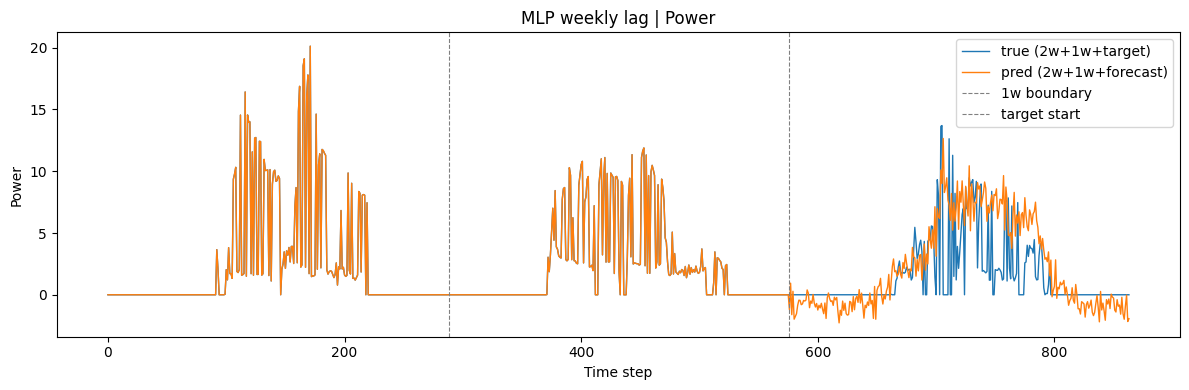

In [28]:
if X_test_n is not None:
    model.eval()
    with torch.no_grad():
        X_test_t = torch.from_numpy(X_test_n).float().to(device)
        pred_n = model(X_test_t).cpu().numpy()

    pred = pred_n * y_std + y_mean
    mse = np.mean((y_test - pred) ** 2)
    mae = np.mean(np.abs(y_test - pred))
    print(f'Test MSE: {mse:.6f} | MAE: {mae:.6f}')

    # plot one example: two prior weeks + target
    ratio = 0.2
    idx = int(ratio * len(X_test)) - 1
    prior2 = X_test[idx][:DAY_STEPS]
    prior1 = X_test[idx][DAY_STEPS:]
    true = y_test[idx]
    pred_y = pred[idx]

    full_true = np.concatenate([prior2, prior1, true])
    full_pred = np.concatenate([prior2, prior1, pred_y])

    plt.figure(figsize=(12, 4))
    plt.plot(full_true, label='true (2w+1w+target)', linewidth=1.0)
    plt.plot(full_pred, label='pred (2w+1w+forecast)', linewidth=1.0)
    plt.axvline(x=DAY_STEPS, color='gray', linestyle='--', linewidth=0.8, label='1w boundary')
    plt.axvline(x=DAY_STEPS*2, color='gray', linestyle='--', linewidth=0.8, label='target start')
    plt.title(f'MLP weekly lag | {TARGET_COL}')
    plt.xlabel('Time step')
    plt.ylabel(TARGET_COL)
    plt.legend()
    plt.tight_layout()
    plt.show()
